# Synthetic data - Making a synthetic dataset of homeowners and their workplaces
In order to develop an algorithm to match residents with the best carpooling partner, we will generate some snythetic data to simulate the problem in the most simple and abstract case. We will make a funciton that will make "resdiential" or "workplace" "centers" and randomly assign each resident to a place of work.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Generate geographical data
First we will make a function to generate our geographical data. We will assume that workplaces and homes are normally distributed around some centers.

In [3]:
def generate_data(centers, labels, nobs):
    """
    Generate observations surrounding `centers`
    Input:
    | centers: <array> [Number of places x 2]
    | labels: <array> Label for each center
    | nobs: <array> Number of observations per distribution [1 x Number of places]
    Output:
    | obs: <array> [nobs*n_centers x 2] 
    """
    np.random.seed(1234)
    # For each center there 
    obs = [[x[0], x[1], label] for center,label,nob in zip(centers, labels, nobs) for x in np.random.normal(center, size=[nob, 2])]
    # # Place in DataFrame
    df = pd.DataFrame(obs,columns=['x','y','label'])
    return df

In [4]:
"""Inputs"""
# Choose location centers
centers = np.array([[1,2], [6,3], [2, 10], [7, 9]])
# Choose location label
labels = ['home','home','work','work']
# Number of observations per center
nobs = [5, 4, 3, 2]

df = generate_data(centers, labels, nobs)
df.head()

,x,y,label
0,1.471435,0.809024,home
1,2.432707,1.687348,home
2,0.279411,2.887163,home
3,1.859588,1.363476,home
4,1.015696,-0.242685,home


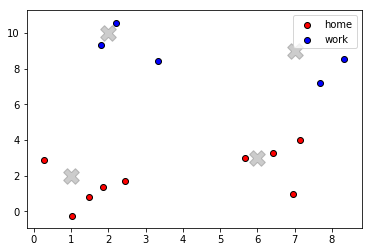

In [5]:
# Plot generated data
plt.scatter(centers[:,0], centers[:,1], marker='X', color='k', s=250, alpha=.2)
palette = {'home':'r', 'work':'b'}

for label in df.label.unique():
    c = palette[label]
    data = df[df.label==label]
    plt.scatter(data.x, data.y,c=c,edgecolor='k', label=label)
plt.legend()
plt.show()

## Assign workplaces

In [6]:
"""Create ids for each location based on whether its a workplace or a home"""
##############################################################################################################
# Initialize  a counter for all labels (in this case it's just 'home' or 'work', but it's good to generalize)
# Increase the counter each time an observation is seen for that label
counters = {label:0 for label in df.label.unique()}
# Create id code for labels
code = {'work':'W', 'home': 'H'}
##############################################################################################################

##############################################################################################################
# Go through each row of the data frame and assign an id based on the location label
ids = []
for label in df.label:
    # Which 'home' or 'workplace' is this?
    count = counters[label]
    # What's the code associated with this id
    c = code[label]
    # Create id for current place
    # *NOTE* String substitution: `%s` is for any string and `%d` is for integers
    ID = '%s_%d'%(c, count)
    
    ids.append(ID)
    # Increase count for this label so the next one will have a unique ID
    counters[label] += 1
##############################################################################################################

# Add these new ids to the dataframe
df['id'] = ids
df.head()

,x,y,label,id
0,1.471435,0.809024,home,H_0
1,2.432707,1.687348,home,H_1
2,0.279411,2.887163,home,H_2
3,1.859588,1.363476,home,H_3
4,1.015696,-0.242685,home,H_4


In [7]:
"""Assign people to workplaces"""
# We want to randomly choose workplaces (with replacements) for each person, meaning we want to `p` random samples of workplace ids, 
# for `p` people

# Find the number of people
p = df[df.label=='home'].id.unique().size

##############################################################################################################
# Randomly choose indices that (will) correspond to each workplace
w = df[df.label=='work'].id.unique().size # Number of workplaces

# Assign an index to each workplace id
# {0: W_0, 1: W_1, ...}
# *NOTE: `enumerate` is the same as `zip([range(len(x)), x])`
w_idx = {idx: wp for idx,wp in enumerate(df[df.label=='work'].id.unique())}
print('w_idx = \n %s'%w_idx)
print()

# We can do the same for ids for people
p_idx = {idx: person for idx,person in enumerate(df[df.label=='home'].id.unique())}
##############################################################################################################

##############################################################################################################
# Randomly choose a workplace to assign to each person. This will only be the "workplace index". We can then use the dictionary
# above to relate this back to our workplace id.
random_idx = np.random.choice(range(w), p, p)
print('Each value below corresponds to the workplace of each person')
print('random_idx = \n %s'%random_idx)

# Now we can convert these indices into the actual ids and assign them to each person
# [[home_1, job_for_home_1], [home_2, job_for_home_2], ...]
assignments = [[p_idx[i],w_idx[idx]] for i,idx in enumerate(random_idx)]
##############################################################################################################

# Now, let's put these assignments into a dataframe containing the 
jobs_df = pd.DataFrame(assignments, columns=['h_id','w_id'])
jobs_df.head()

w_idx = 
 {0: 'W_0', 1: 'W_1', 2: 'W_2', 3: 'W_3', 4: 'W_4'}

Each value below corresponds to the workplace of each person
random_idx = 
 [2 3 4 1 4 0 4 1 1]


,h_id,w_id
0,H_0,W_2
1,H_1,W_3
2,H_2,W_4
3,H_3,W_1
4,H_4,W_4


## Data wrangling
Now we have two datasets

1. Geographical locations of places (homes and workplaces)
2. Where each person works

Our next task is to some data wrangling to combine these datasets. Let's make a new (and final) dataframe that for each row contains:

1. Their id (h_id)
2. Where they live (x_home, y_home)
3. Their workplace's id (w_id)
4. Their workplace's coordinates (x_work, y_work)

In [8]:
"""Might be easiest to make a dataframe for each type of location and go from there"""
# Also, remove `label` column. With separate dfs for each type of data, we don't need to label 
# To remove `label` column, let's only take `x`,`y`, and `id` from each dataframe
homes = df[df.label=='home'][['x','y','id']].rename(columns = {'id':'h_id','x':'x_home','y':'y_home'})
workplaces = df[df.label=='work'][['x','y','id']].rename(columns = {'id':'w_id','x':'x_work','y':'y_work'})

# Add work ids to each person
data = homes.merge(jobs_df)
print('Adding work ids')
print(data.head())
print()

# Add workplace coordinates
data = data.merge(workplaces)

# Since each row is unique to the person, let's set their id as the index
data = data.set_index('h_id')
data.head()

Adding work ids
     x_home    y_home h_id w_id
0  1.471435  0.809024  H_0  W_2
1  2.432707  1.687348  H_1  W_3
2  0.279411  2.887163  H_2  W_4
3  1.859588  1.363476  H_3  W_1
4  1.015696 -0.242685  H_4  W_4



,x_home,y_home,w_id,x_work,y_work
h_id,,,,,
H_0,1.471435,0.809024,W_2,2.193421,10.553439
H_1,2.432707,1.687348,W_3,8.318152,8.530695
H_2,0.279411,2.887163,W_4,7.675554,7.182973
H_4,1.015696,-0.242685,W_4,7.675554,7.182973
H_6,6.953324,0.978745,W_4,7.675554,7.182973


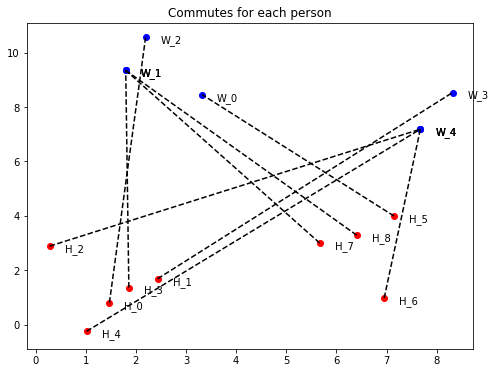

In [12]:
"""Now, let's visualize the relationship between each person and their workplace"""
plt.figure(figsize=(8,6))
# For each person
for person in data.index:
    # Grab the data for this person
    curr = data.loc[person]
    
    # Plot the location of the person's home
    plt.scatter(curr.x_home, curr.y_home, c='r')
    # Plot the location of their work
    plt.scatter(curr.x_work, curr.y_work, c='b')
    
    # Annotate points 
    plt.annotate(person, xy=(curr.x_home+.3, curr.y_home-.2))
    plt.annotate(curr.w_id, xy=(curr.x_work+.3, curr.y_work-.2))
    
    # Plot a line between that person's home and their workplace
    # We have to plot with plt.plot([x1,x2], [y1,y2])
    plt.plot([curr.x_home,curr.x_work], [curr.y_home, curr.y_work], 'k--')
plt.title('Commutes for each person')
plt.show()

## Analysis
Notice, that by random chance, one of the possible options for work was not selected. More importantly noticce that we have some obvious carpooling candidates! `H_0` and `H_3` should clearly carpool to work together. While they don't work at the same place, there's only a marginal distance between `W_1` and `W_2`. Likewise `H_4` should pick up `H_1` on their way to work.

**Our goal** is to make an algorithm that would be able to properly identify these optimal pairings for each person. In some cases, those pairings will be too time consuming to be taken seriously, but that optimal pairing still exists

# More realistic sized dataset
Here, I will use some of the functions from above and some more concise coding to create a larger dataset for modeling a more realistic scenario.

In [73]:
"""Generate data"""
n_workcenters = 10
n_neighborhoods = 40
np.random.seed(1234)
centers = np.random.uniform(0,100,(n_workcenters+n_neighborhoods, 2))
labels = ['work']*n_workcenters + ['home']*n_neighborhoods
np.random.seed(1234)
nobs = list(np.random.randint(5,10,n_workcenters)) + list(np.random.randint(15,40,n_neighborhoods))
df = generate_data(centers, labels, nobs)
df.head()

,x,y,label
0,19.623380,61.019901,work
1,20.584652,61.898225,work
2,18.431356,63.098040,work
3,20.011533,61.574354,work
4,19.167641,59.968192,work


In [74]:
"""Assign workplaces"""
home_idx = df[df.label=='home'].index
np.random.seed(1234)
# Job assignments
jobs_df = pd.DataFrame([[h,w] for h,w in zip(home_idx, np.random.choice(df[df.label=='work'].index,home_idx.size))], columns=['h_id','w_id'])
# Merge home coordinates and work coordiantes
data = df[df.label=='home'].join(jobs_df.set_index('h_id')).set_index('w_id').join(df[df.label=='work'], rsuffix='_work').reset_index(drop=True)
data = data[[c for c in data if 'label' not in c]]
data.head()

,x,y,x_work,y_work
0,36.074094,60.113823,19.62338,61.019901
1,7.561629,37.436178,19.62338,61.019901
2,72.125556,71.740968,19.62338,61.019901
3,20.293074,92.014382,19.62338,61.019901
4,4.711490,18.166385,19.62338,61.019901


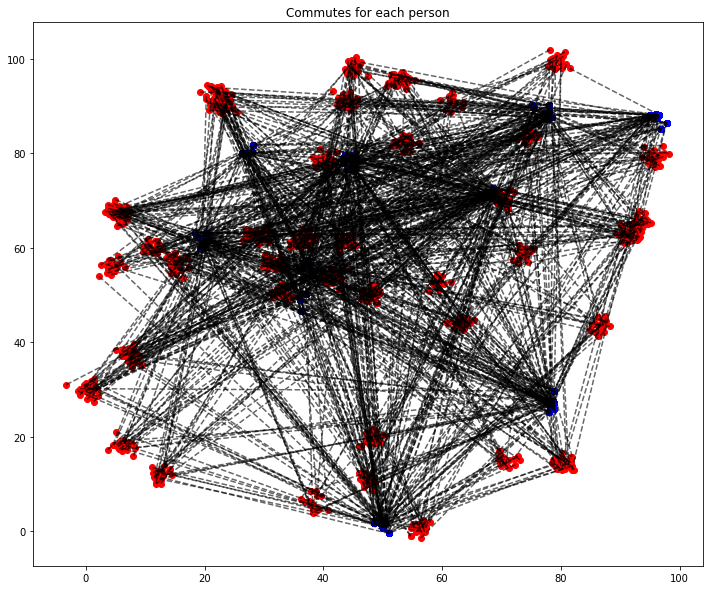

In [76]:
plt.figure(figsize=(12,10))
# For each person
for person in data.index:
    # Grab the data for this person
    curr = data.loc[person]
    
    # Plot the location of the person's home
    plt.scatter(curr.x, curr.y, c='r')
    # Plot the location of their work
    plt.scatter(curr.x_work, curr.y_work, c='b')
    
    # Plot a line between that person's home and their workplace
    # We have to plot with plt.plot([x1,x2], [y1,y2])
    plt.plot([curr.x,curr.x_work], [curr.y, curr.y_work], 'k--', alpha=.6)
plt.title('Commutes for each person')
plt.show()

## Well... looks like we have a lot of work to do